# AODS_Assi_3_Disease Diagnosis Prediction.ipynb

In [2]:
!pip install faker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 19.1 MB/s eta 0:00:00


In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import seaborn as sns


# 1. Formulate any problem of your choice to solve and want to get the data.

In [6]:
# The problem is to generate a dummy dataset for disease diagnosis prediction using a GAN model.

def generate_real_data(num_records=1000):
    data = {
        'Age': np.random.randint(18, 80, num_records),
        'Gender': np.random.choice([0, 1], num_records),  # 0: Male, 1: Female
        'Symptoms Duration': np.random.randint(1, 30, num_records),
        'Body Temperature': np.round(np.random.uniform(36.5, 40.0, num_records), 1),
        'Heart Rate': np.random.randint(60, 120, num_records),
        'Blood Pressure': np.random.choice([0, 1, 2], num_records),  # 0: Low, 1: Normal, 2: High
        'Chronic Illness': np.random.choice([0, 1], num_records),
        'Smoking Habit': np.random.choice([0, 1], num_records),
        'Water Intake': np.round(np.random.uniform(1, 5, num_records), 1),
        'Diagnosis Label': np.random.choice([0, 1], num_records)  # 0: No Disease, 1: Disease
    }
    return pd.DataFrame(data)

# 2. Install any library for generating dummy data.

In [7]:
# Required libraries: numpy, pandas, torch, sklearn, matplotlib, seaborn (Make sure these are installed)
df = generate_real_data()
df

,Age,Gender,Symptoms Duration,Body Temperature,Heart Rate,Blood Pressure,Chronic Illness,Smoking Habit,Water Intake,Diagnosis Label
0,76,0,22,39.1,68,2,1,1,4.2,1
1,21,0,2,39.7,71,2,0,1,4.7,0
2,74,0,29,36.6,60,1,0,0,4.2,0
3,41,1,8,36.7,62,1,1,1,2.5,1
4,77,0,4,39.3,68,2,1,1,2.3,0
...,...,...,...,...,...,...,...,...,...,...
995,23,1,29,37.4,69,2,0,1,2.7,0
996,44,0,1,37.9,62,0,1,1,1.9,0
997,20,0,26,38.2,110,1,1,1,1.5,0
998,69,0,25,38.7,102,0,0,1,2.0,1


# 3. Select any generative model and generate dummy data.

In [8]:
# Using a Generative Adversarial Network (GAN)
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = torch.tensor(df_scaled, dtype=torch.float32)
df_scaled

tensor([[0.9508, 0.0000, 0.7500,  ..., 1.0000, 0.8000, 1.0000],
        [0.0492, 0.0000, 0.0357,  ..., 1.0000, 0.9250, 0.0000],
        [0.9180, 0.0000, 1.0000,  ..., 0.0000, 0.8000, 0.0000],
        ...,
        [0.0328, 0.0000, 0.8929,  ..., 1.0000, 0.1250, 0.0000],
        [0.8361, 0.0000, 0.8571,  ..., 1.0000, 0.2500, 1.0000],
        [0.4590, 1.0000, 0.8571,  ..., 1.0000, 0.6000, 0.0000]])

In [9]:
class Generator(nn.Module):
    def __init__(self, noise_dim, output_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 16),
            nn.ReLU(),
            nn.Linear(16, output_dim),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.model(x)

# 4. Generate dummy data with at least 1000 instances and a minimum 7-10 attributes.

In [11]:
noise_dim, input_dim = 10, df_scaled.shape[1]
batch_size, num_epochs, lr = 32, 5000, 0.001
generator, discriminator = Generator(noise_dim, input_dim), Discriminator(input_dim)
loss_function = nn.BCELoss()
optimizer_g, optimizer_d = optim.Adam(generator.parameters(), lr=lr), optim.Adam(discriminator.parameters(), lr=lr)
data_loader = DataLoader(TensorDataset(df_scaled), batch_size=batch_size, shuffle=True)

In [12]:
# Training GAN
for epoch in range(num_epochs):
    for real_data, in data_loader:
        batch_size = real_data.shape[0]
        real_labels, fake_labels = torch.ones(batch_size, 1), torch.zeros(batch_size, 1)
        noise = torch.randn(batch_size, noise_dim)
        fake_data = generator(noise)
        real_loss = loss_function(discriminator(real_data), real_labels)
        fake_loss = loss_function(discriminator(fake_data.detach()), fake_labels)
        d_loss = real_loss + fake_loss
        optimizer_d.zero_grad(); d_loss.backward(); optimizer_d.step()
        noise = torch.randn(batch_size, noise_dim)
        fake_data = generator(noise)
        g_loss = loss_function(discriminator(fake_data), real_labels)
        optimizer_g.zero_grad(); g_loss.backward(); optimizer_g.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}")

Epoch 0: D Loss: 1.3588, G Loss: 0.6907
Epoch 500: D Loss: 0.9799, G Loss: 1.0705
Epoch 1000: D Loss: 1.2660, G Loss: 0.9067
Epoch 1500: D Loss: 1.5358, G Loss: 0.8683
Epoch 2000: D Loss: 1.2725, G Loss: 1.2459
Epoch 2500: D Loss: 1.3791, G Loss: 0.8099
Epoch 3000: D Loss: 1.3278, G Loss: 0.7434
Epoch 3500: D Loss: 1.3348, G Loss: 0.9632
Epoch 4000: D Loss: 1.7338, G Loss: 0.4876
Epoch 4500: D Loss: 1.4077, G Loss: 0.5790


# 5. Label the data according to the domain problem.


### Labels are assigned in the dataset as 'Diagnosis Label' (0: No Disease, 1: Disease)

# 6. Compare any two models

In [14]:
# Here, we can compare GAN-generated data vs. real data distribution.
num_fake_samples = 1000
noise = torch.randn(num_fake_samples, noise_dim)
fake_data = generator(noise).detach().numpy()
fake_data = scaler.inverse_transform(fake_data)
df_fake = pd.DataFrame(fake_data, columns=df.columns).round(2)
print(df_fake.head())


         Age  Gender  Symptoms Duration  Body Temperature  Heart Rate  \
0  74.169998     1.0               3.61         36.700001   60.480000   
1  48.990002     0.0               3.21         36.860001   73.279999   
2  76.620003     1.0               3.50         36.810001   60.590000   
3  58.540001     0.0               2.75         36.970001   66.809998   
4  70.650002     0.0               1.22         36.799999   61.680000   

   Blood Pressure  Chronic Illness  Smoking Habit  Water Intake  \
0            1.06              0.0            0.0          3.59   
1            0.12              1.0            1.0          2.88   
2            2.00              1.0            0.0          3.94   
3            2.00              1.0            1.0          2.95   
4            2.00              0.0            0.0          3.24   

   Diagnosis Label  
0              1.0  
1              1.0  
2              0.0  
3              0.0  
4              1.0  



# 7. Draw comparison between model performance on model generated data and library generated data.

In [16]:
# Ensure Diagnosis Label is binary (0 or 1)
df_fake['Diagnosis Label'] = (df_fake['Diagnosis Label'] > 0.5).astype(int)

print(df_fake.head())

         Age  Gender  Symptoms Duration  Body Temperature  Heart Rate  \
0  74.169998     1.0               3.61         36.700001   60.480000   
1  48.990002     0.0               3.21         36.860001   73.279999   
2  76.620003     1.0               3.50         36.810001   60.590000   
3  58.540001     0.0               2.75         36.970001   66.809998   
4  70.650002     0.0               1.22         36.799999   61.680000   

   Blood Pressure  Chronic Illness  Smoking Habit  Water Intake  \
0            1.06              0.0            0.0          3.59   
1            0.12              1.0            1.0          2.88   
2            2.00              1.0            0.0          3.94   
3            2.00              1.0            1.0          2.95   
4            2.00              0.0            0.0          3.24   

   Diagnosis Label  
0                1  
1                1  
2                0  
3                0  
4                1  


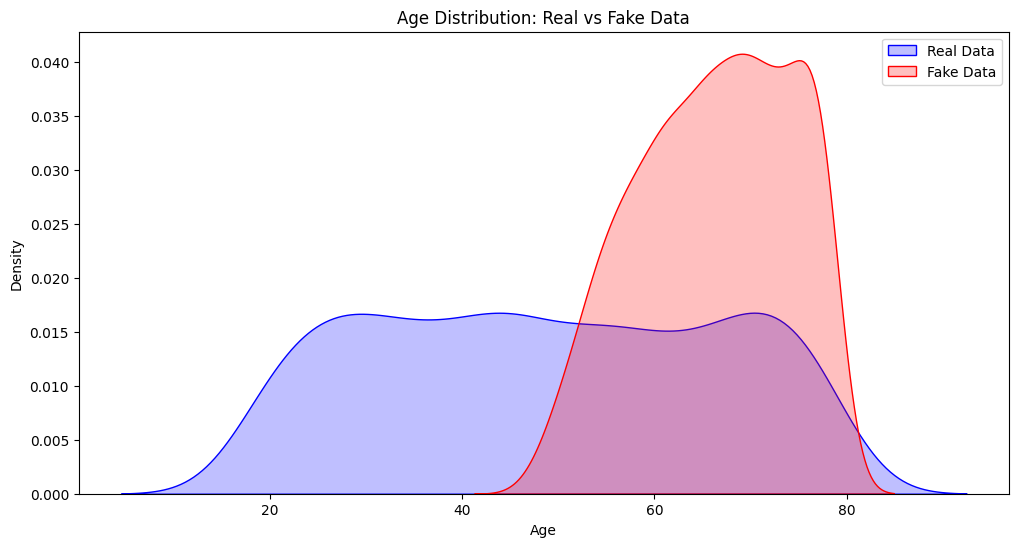

In [17]:
# 7. Draw comparison between model performance on model generated data and library generated data.
plt.figure(figsize=(12, 6))
sns.kdeplot(df['Age'], label='Real Data', color='blue', fill=True)
sns.kdeplot(df_fake['Age'], label='Fake Data', color='red', fill=True)
plt.legend(); plt.title("Age Distribution: Real vs Fake Data")
plt.show()

In [18]:
# Train a model on both real and fake data
X_real, y_real = df.drop(columns=['Diagnosis Label']), df['Diagnosis Label']
X_fake, y_fake = df_fake.drop(columns=['Diagnosis Label']), df_fake['Diagnosis Label']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, test_size=0.2, random_state=42)
X_train_fake, X_test_fake, y_train_fake, y_test_fake = train_test_split(X_fake, y_fake, test_size=0.2, random_state=42)

In [21]:
model_real = LogisticRegression()
model_real.fit(X_train_real, y_train_real)

LogisticRegression()

In [22]:
model_fake = LogisticRegression()
model_fake.fit(X_train_fake, y_train_fake)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [23]:
y_pred_real = model_real.predict(X_test_real)
y_pred_fake = model_fake.predict(X_test_fake)

In [24]:
acc_real = accuracy_score(y_test_real, y_pred_real)
acc_fake = accuracy_score(y_test_fake, y_pred_fake)
print(f"Accuracy on Real Data: {acc_real:.4f}")
print(f"Accuracy on Fake Data: {acc_fake:.4f}")

Accuracy on Real Data: 0.5050
Accuracy on Fake Data: 0.8450


In [29]:
from sklearn.ensemble import RandomForestClassifier

# Train a Random Forest model on both real and fake data
rf_model_real = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_fake = RandomForestClassifier(n_estimators=100, random_state=42)

rf_model_real.fit(X_train_real, y_train_real)
rf_model_fake.fit(X_train_fake, y_train_fake)

# Predictions
y_pred_rf_real = rf_model_real.predict(X_test_real)
y_pred_rf_fake = rf_model_fake.predict(X_test_fake)

In [30]:
# Accuracy
acc_rf_real = accuracy_score(y_test_real, y_pred_rf_real)
acc_rf_fake = accuracy_score(y_test_fake, y_pred_rf_fake)

In [31]:
# Print results
print(f"Accuracy on Real Data (Random Forest): {acc_rf_real:.4f}")
print(f"Accuracy on Fake Data (Random Forest): {acc_rf_fake:.4f}")

Accuracy on Real Data (Random Forest): 0.4400
Accuracy on Fake Data (Random Forest): 0.9250


Accuracy on Real Data (Random Forest): 0.4400
Accuracy on Fake Data (Random Forest): 0.9250


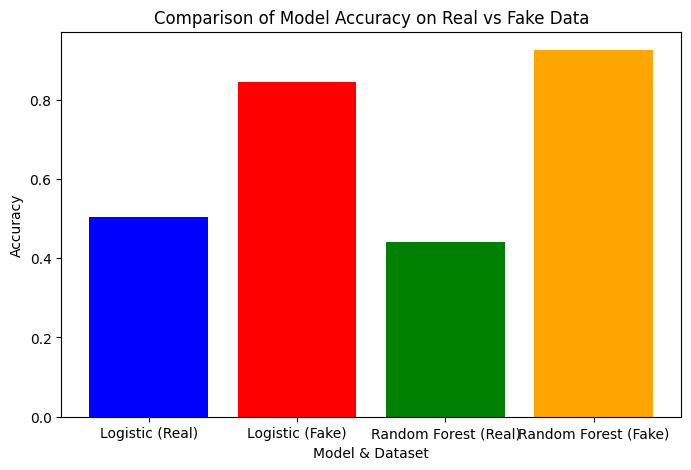

In [28]:
# Update Graph to Compare Logistic Regression & Random Forest
plt.figure(figsize=(8,5))
models = ["Logistic (Real)", "Logistic (Fake)", "Random Forest (Real)", "Random Forest (Fake)"]
accuracies = [acc_real, acc_fake, acc_rf_real, acc_rf_fake]
colors = ['blue', 'red', 'green', 'orange']

plt.bar(models, accuracies, color=colors)
plt.xlabel("Model & Dataset")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy on Real vs Fake Data")
plt.show()
